# Classification and regression trees (CARTs)

Decision trees are an extremely popular and powerful technique in machine learning for building classification and regression models.

To perform classification or regression, decision trees make **sequential, hierarchical decisions about the outcome variable based on the predictor data.**

## sklearn code for fitting CARTs

---

[Classification CART documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

[Regression CART documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)

[Decision tree user guide](http://scikit-learn.org/stable/modules/tree.html)

---

In [21]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import sklearn.datasets as datasets

b = datasets.load_boston()
X, Y = b['data'], b['target']

# criterion: splitting decision function (discussed later), can be 'gini' or 'entropy'
# max_depth: the maximum number of hierarchical decision nodes (how "deep" the tree is built)
#
classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=None)

regressor = DecisionTreeRegressor(criterion='mse',
                                  max_depth=5)

regressor.fit(X, Y)

Y_pred = regressor.predict(X)

# decision trees can give us feature importances. the higher the number the more important
# the predictor was to deciding splits at nodes.
# "The importance of a feature is computed as the (normalized) total reduction of the 
# criterion brought by that feature."
#
feature_importances = regressor.feature_importances_

## Properties of decision trees

Decision tree models are **hierarchical** and **non-parametric**.

**Hierarchical** means that the model is definied by a sequence of questions which yield a class label or value when applied to any observation. Once trained, the model behaves like a recipe, a series of "if this then that" conditions that yields a specific result for our input data.

[**Non-parametric** methods](https://en.wikipedia.org/wiki/Nonparametric_statistics) stand in contrast to models like logistic regression or ordinary least squares regression. There are no underlying assumptions about the distribution of the data or the errors. Non-parametric models essentially start with no _assumed_ parameters about the data and construct them based on the observed data.

## Example decision tree: should I play golf?

---

![deciding to play golf](../assets/images/golf-tree.png)

## Directed Acyclic Graphs (DAG)

CART models are in fact a special case of [Directed Acyclic Graphs (DAG).](https://en.wikipedia.org/wiki/Directed_acyclic_graph) 

DAGs have **nodes** and **edges**. In the golf example above, the nodes represent the decision points about the output variable given the predictors, and the edges are the "paths" between nodes that represent answers to the questions.

The **acyclic** part of DAGs means that the edges do not cycle back on themselves.

- The top node is called the **root node**. It has 0 incoming edges, and 2+ outgoing edges. 
- Internal nodes test a condition on a specific feature. They have 1 incoming edge, and 2+ outgoing edges. 
- A **leaf node** contains a class label (or regression value). It has 1 incoming edge and 0 outgoing edges.

### General DAG example

---

![DAG example](https://upload.wikimedia.org/wikipedia/commons/0/08/Directed_acyclic_graph.png)

## Building a decision tree

Building decision trees requires algorithms capable of determining an optimal choice at each node. 

One such algorithm is [**Hunt's algorithm**](http://mines.humanoriented.com/classes/2010/fall/csci568/portfolio_exports/lguo/decisionTree.html). This is a **greedy, recursive** algorithm that leads to a **local optimum**.

Lots of new vocabulary there:

- [**Greedy:**](https://en.wikipedia.org/wiki/Greedy_algorithm) the algorithm makes the most optimal decision it can at each step.
- [**Recursive:**](https://en.wikipedia.org/wiki/Recursion) the algorithm splits task into subtasks and solves each the same way.
- [**Local optimum:**](https://en.wikipedia.org/wiki/Local_optimum) the algorithm finds a solution just for the given neighborhood of points.

The algorithm works by recursively partitioning records into smaller and smaller subsets. The partitioning decision is made at each node according to a metric called **purity.** A node is said to be 100% pure when all of its records belong to a single class (or have the same value).

### Pseudocode classification decision tree algorithm

---

    Given a set of records Dt at node t:
        If all records in Dt belong to class A: 
            t is a leaf node corresponding to class (Base case)
        Else if Dt contains records from both A and B:
            Create test condition to partition the observations
            Define t as an internal node, with outgoing edges to child nodes
            partition records in Dt with conditional test logic to child nodes
            Recursively apply steps at each child node.

- Splits can be binary way or multi-way. 
- Features can be categorical or continuous.

### Multi-way splits

---

![multi-way](../assets/images/multi-way.png)

### Continuous measure decisions (regression trees)

---

![continuous trees](../assets/images/Continuous-features.png)

## Optimization and "purity"

Recall from the algorithm above we iteratively create **test conditions** to split the data. 

---


A **maximum impurity** partition is given by the distribution (classification):

### $$ p(0|t) = p(1|t) = 0.5 $$

where both classes are present equally.

**Maximum purity** is obtained when only one class is present, i.e: 

### $$ p(0|t) = 1 – p(1|t) = 1 $$

### Purity objective function

To achieve maximum purity we need an **objective function** to optimize. 

We want our objective function to measure the **gain in purity** from a particular split. Therefore it depends on the class distribution over the nodes (before and after the split). 

For example, let 

### $$p(i|t)$$ 

be the probability of **`class i`** at **`node t`** (e.g., the fraction of records labeled **`i`** at node **`t`**) 

We then define an impurity function that will smoothly vary between the two extreme cases of minimum impurity (one class or the other only) and the maximum impurity case cas as an equal mix.

## Common purity functions

---

## $$ \text{Entropy}(t) = - \sum_{i=0}^{c-1} p(i|t)log_2 p(i|t) $$

## $$ \text{Gini}(t) = 1 - \sum_{i=0}^{c-1} [p(i|t)]^2 $$

## $$ \text{Classification error}(t) = 1 - \max_i[p(i|t)] $$

![purity functions](../assets/images/measures.png)

---

Impurity measures on their own they are not enough to tell us how a split will do. We need to look at impurity **before & after** the split. We can make this comparison using what is called the **gain**: 

## $$ \Delta = I(\text{parent}) - \sum_{\text{children}}\frac{N_j}{N}I(\text{child}_j) $$

Where $I$ is the impurity measure, $N_j$ denotes the number of records at child node $j$, and $N$ denotes the number of records at the parent node. When $I$ is the [**entropy function**](https://en.wikipedia.org/wiki/Binary_entropy_function), this quantity is called the [**information gain**](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees).

In [22]:
import numpy as np
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor

from ipywidgets import *
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(9, 7))
sns.set_style('whitegrid')

%matplotlib inline

In [23]:
# We will make some data for these functions of 100 points of x from 0.1 to 10:
# 
# 1. The general log function for x
# 2. The sin function
# 3. The exponential function
# 4. The x**2 function
#
def make_data(points=100):
    x = np.linspace(0.1, 10, points)
    
    data = {
        'x':x,
        'ygenlog':stats.genlogistic.pdf(x, 20)*500 + np.random.normal(0, 2, size=points),
        'ysin':np.sin(x)*20 + np.random.normal(0, 2, size=points),
        'yexp':np.exp(x/1.3) + np.random.normal(0, 2, size=points),
        'ysq':(x-5)**2 + np.random.normal(0, 1, size=points)
    }

    return data

# The data is put into a dictionary for convenience:
d = make_data()
x = d['x']

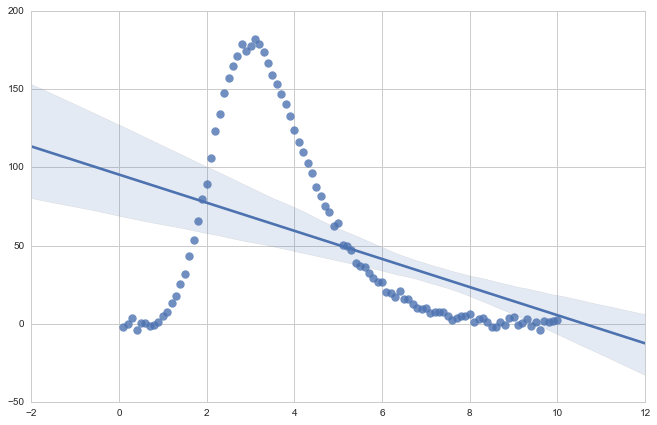

In [24]:
fig = plt.figure(figsize=(11, 7))
sns.regplot(x=x, y=d['ygenlog'], scatter_kws={'s':70})

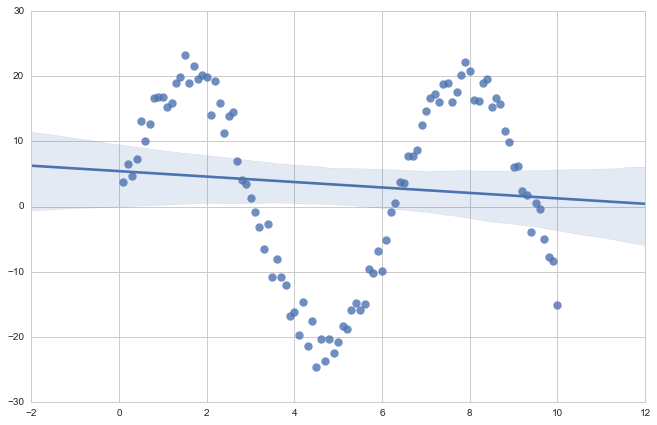

In [25]:
fig = plt.figure(figsize=(11, 7))
sns.regplot(x=x, y=d['ysin'], scatter_kws={'s':70})

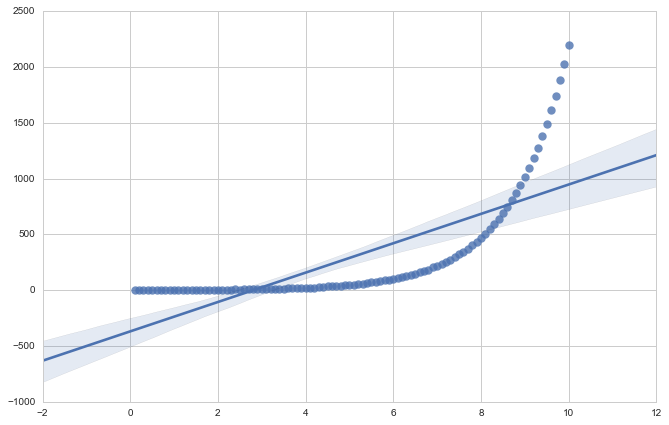

In [26]:
fig = plt.figure(figsize=(11, 7))
sns.regplot(x=x, y=d['yexp'], scatter_kws={'s':70})

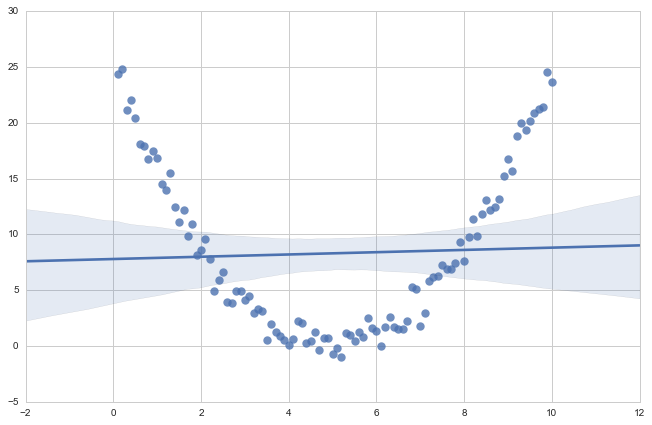

In [27]:
fig = plt.figure(figsize=(11, 7))
sns.regplot(x=x, y=d['ysq'], scatter_kws={'s':70})

In [28]:
# This function builds trees for an x and y predictor and dependent variable from depth 1 to 10.
# (Regression trees)
# Tree predictions are put into a dictionary:
# 
def build_tree_models(x, y, tree_depth_range=range(1,11)):
    tree_model_ypreds = {}
    
    for i in tree_depth_range:
        model = DecisionTreeRegressor(max_depth=i)
        model.fit(x[:, np.newaxis], y)
        tree_model_ypreds[i] = model.predict(x[:, np.newaxis])
        
    return tree_model_ypreds

# A function to iterate through our data dictionary of different functions and build the tree models:
#
def fit_trees(data_dict):
    trees_dict = {}
    x = data_dict['x']
    for label, ys in data_dict.items():
        if not label == 'x':
            tree_ys = build_tree_models(x, ys)
            trees_dict[label] = tree_ys
    
    return trees_dict

tr = fit_trees(d)
    

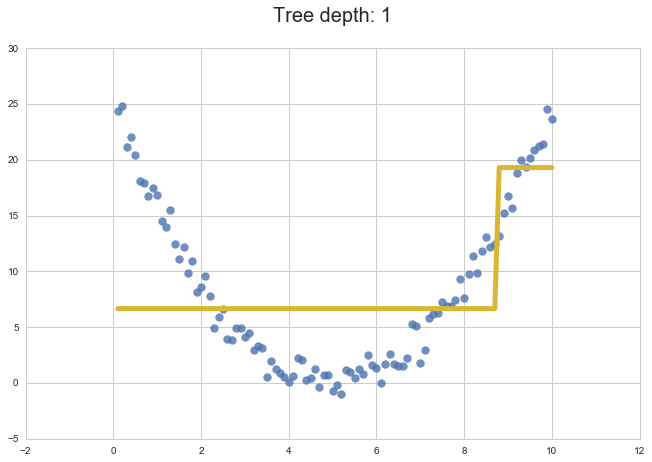

<function __main__.tree_plot_vars>

In [29]:
# This function plots the x and y data as well as the decision tree decisions for the predicted y:
#
def tree_plotter(d, tr, label, treenum):
    fig = plt.figure(figsize=(11, 7))
        
    x = d['x']
    y_true = d[label]
    y_pred = tr[label][treenum]
    
    ax = sns.regplot(x=x, y=y_true, scatter_kws={'s':70}, fit_reg=False, x_ci=None, ci=None)
    
    ax.plot(x, y_pred, c="#D7B734", linewidth=5)
    
    ax.set_title('Tree depth: '+str(treenum)+'\n', fontsize=20)
    
    plt.show()
    

# Widget inputs code:
#
def tree_plot_vars(function='ysq', treenum=1):
    tree_plotter(d, tr, function, treenum)
    
    
widgets.interact(tree_plot_vars,
                 function=('ysq','yexp','ysin','ygenlog'),
                 treenum=widgets.IntSlider(min=1, max=10, step=1, continuous_update=False, value=1))


In [30]:
# Make a single regression tree model with depth 3 for x**2 function:
# 
x = d['x']
y = d['ysq']

dtree = DecisionTreeRegressor(max_depth=3)
dtree.fit(x[:, np.newaxis], y)


DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [31]:
# REQUIREMENTS:
# pip install pydot2
# brew install graphviz

# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydot

dot_data = StringIO()  

export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

Couldn't import dot_parser, loading of dot files will not be possible.


NameError: global name 'dot_parser' is not defined

In [ ]:
# Plot the decisions for y based on the decision tree DAG above
#
tree_plotter(d, tr, 'ysq', 3)

## Overfitting

Recall the **stopping criterion** determines when to no longer construct further nodes. 

We can stop when all records belong to the same class, or when all records have the same attributes. This [**maximizes variance at the expense of bias**](http://blog.fliptop.com/blog/2015/03/02/bias-variance-and-overfitting-machine-learning-overview/), leading to overfitting. 

**Subtree replacement:**
One possible way to prevent overfitting is **pre-pruning**, which involves setting a minimum threshold on the gain, and stopping when no split achieves a gain above this threshold. It is difficult to calibrate in practice.

**Subtree raising:**
Alternatively we can build the full tree and then perform pruning as a post-processing step. To prune a tree, the nodes are examinde from the bottom-up and pieces of the tree are simplified according to some criteria. Complicated subtrees can be replaced either with a single node or with a simpler (child) subtree. 


## CART advantages

- Simple to understand and interpret. People are able to understand decision tree models after a brief explanation.
    - Useful to work with non technical departments (marketing/sales).
- Requires little data preparation. 
    - Other techniques often require data normalization, dummy variables need to be created and blank values to be removed.
- Able to handle both numerical and categorical data. 
    - Other techniques are usually specialized in analyzing datasets that have only one type of variable.
- Uses a **white box** model.
    - If a given situation is observable in a model the explanation for the condition is easily explained by boolean logic.
    - By contrast, in a **black box** model, the explanation for the results is typically difficult to understand, for example in neural networks.
- Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.
- Robust. Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.
- Performs well with large datasets. Large amounts of data can be analyzed using standard computing resources in reasonable time.
- Once trained can be implemented on hardware and has extremely fast execution.
    - Real-time applications like trading, for example.

## CART disadvantages

- Locally-optimal.
    - Practical decision-tree learning algorithms are based on heuristics such as the greedy algorithm where locally-optimal decisions are made at each node. 
    - Such algorithms cannot guarantee to return the globally-optimal decision tree.
- Overfitting.
    - Decision-tree learners can create over-complex trees that do not generalize well from the training data.
- There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems. In such cases, the decision tree becomes prohibitively large.
    - Neural networks, for example, are superior for these problems.
- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.